In [1]:
import os
import sys
import time
import requests
import pandas as pd
import numpy as np
import QuantLib as ql
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from itertools import product
from datetime import datetime
from datetime import timedelta

from model_settings import ms
from plotters import plot_surface
from av_fetchers import underlying, link

search_symbol = 'SPY'
url = f"https://www.alphavantage.co/query?function=SYMBOL_SEARCH&keywords={search_symbol}&apikey={ms.av_key}"
r = requests.get(url)
data = r.json()
pd.DataFrame(data['bestMatches'])

,1. symbol,2. name,3. type,4. region,5. marketOpen,6. marketClose,7. timezone,8. currency,9. matchScore
0,SPY,SPDR S&P 500 ETF Trust,ETF,United States,09:30,16:00,UTC-04,USD,1.0000
1,SPY1.FRK,SSgA SPDR ETFs Europe I Public Limited Company...,ETF,Frankfurt,08:00,20:00,UTC+02,EUR,0.6667
2,SPY2.FRK,SSgA SPDR ETFs Europe I Public Limited Company...,ETF,Frankfurt,08:00,20:00,UTC+02,EUR,0.6667
3,SPY3.LON,Leverage Shares 3x Long US 500 ETP Securities,ETF,United Kingdom,08:00,16:30,UTC+01,USD,0.6667
4,SPY4.FRK,SSgA SPDR S&P 400 US Mid Cap,ETF,Frankfurt,08:00,20:00,UTC+02,EUR,0.6667
5,SPY4.LON,SPDR® S&P 400 US Mid Cap UCITS ETF,ETF,United Kingdom,08:00,16:30,UTC+01,USD,0.6667
6,SPY1.DEX,SPDR® S&P 500 Low Volatility UCITS ETF,ETF,XETRA,08:00,20:00,UTC+02,EUR,0.6000
7,SPY2.DEX,SPDR® Dow Jones Global Real Estate UCITS ETF U...,ETF,XETRA,08:00,20:00,UTC+02,EUR,0.6000
8,SPY4.DEX,SSgA SPDR S&P 400 US Mid Cap,ETF,XETRA,08:00,20:00,UTC+02,EUR,0.6000
9,SPY4.PAR,SSgA SPDR S&P 400 US Mid Cap,ETF,Paris,09:00,17:30,UTC+02,EUR,0.6000


In [2]:
symbol = search_symbol
spots = underlying(symbol,ms.av_key)
spots = pd.Series(spots).astype(float)

# example data collection

let us collect a few recent trading days and inspect the data

In [3]:
dates = pd.Series(spots).index
dates = pd.Series(dates[:5])
print(dates)

0    2024-12-18
1    2024-12-17
2    2024-12-16
3    2024-12-13
4    2024-12-12
dtype: object


In [4]:
spots

2024-12-18    586.2800
2024-12-17    604.2900
2024-12-16    606.7900
2024-12-13    604.2100
2024-12-12    604.3300
                ...   
1999-11-05    137.8750
1999-11-04    136.5312
1999-11-03    135.5000
1999-11-02    134.5937
1999-11-01    135.5625
Length: 6324, dtype: float64

In [5]:
chain = {}
bar = tqdm(total=len(dates))
for date in dates:
    spot = float(spots[date])
    chain_link = link(date,symbol,ms.av_key)
    printdate = datetime.strptime(date, '%Y-%m-%d').strftime('%A, %Y-%m-%d')
    chain[date] = chain_link
    bar.update(1)
bar.close()

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.56s/it]


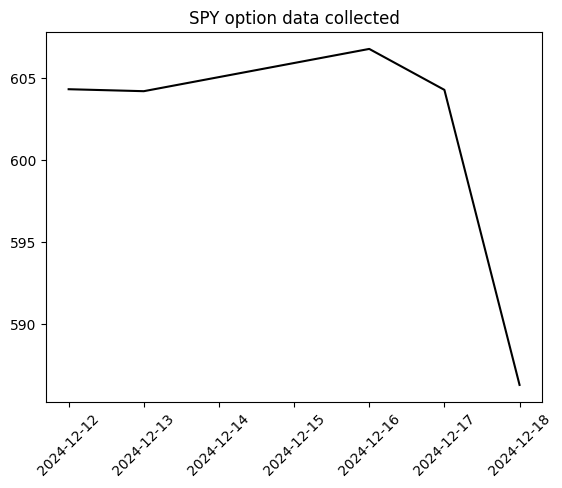

<Figure size 640x480 with 0 Axes>

In [6]:
demo_spots = spots[dates]
demo_spots.index = pd.to_datetime(demo_spots.index, format='%Y-%m-%d')
plt.figure()
plt.plot(demo_spots,color='black')
plt.title(f'{symbol} option data collected')
plt.xticks(rotation=45)
plt.show()
plt.clf()

# example calibraion

now why not select the one trading day and proceed with an example calibration of our Heston (1993) model

In [7]:
date = dates[0]
raw_data = pd.DataFrame(chain[date])
calculation_datetime = datetime.strptime(date,'%Y-%m-%d')
calculation_date = ql.Date(
    calculation_datetime.day,
    calculation_datetime.month,
    calculation_datetime.year,
)
notebook_printdate = str(calculation_datetime.strftime('%A, '))+str(calculation_date)
print(notebook_printdate)

Wednesday, December 18th, 2024


## extracting calibration contracts

In [8]:
df = raw_data.copy()
df['volume'] = pd.to_numeric(df['volume'])
df['implied_volatility'] = pd.to_numeric(df['implied_volatility'])
df['strike'] = pd.to_numeric(df['strike'])
df['volume'] = pd.to_numeric(df['volume'])
df['expiration'] = pd.to_datetime(df['expiration'],format='%Y-%m-%d')
df['date'] = pd.to_datetime(df['date'],format='%Y-%m-%d')
df['days_to_maturity'] = df['expiration'] - df['date']
df['days_to_maturity'] = df['days_to_maturity'] / np.timedelta64(1, 'D')
df['days_to_maturity'] = df['days_to_maturity'].astype('int64')
df = df[df['days_to_maturity']>=7]
df = df[df['volume']>0].copy()
df['spot_price'] = spot
df['moneyness'] = ms.vmoneyness(df['spot_price'],df['strike'],df['type'])
df = df[(df['moneyness']<0)&(df['moneyness']>-0.5)]
pivoted = df.pivot(index = 'strike',columns='days_to_maturity',values='implied_volatility')


T = np.sort(df['days_to_maturity'].unique())
T = T[T<400]
T = T[np.linspace(0, len(T) - 1, num=5, dtype=int)]

K = np.sort(df['strike'].unique())
K1 = np.sort(pivoted.dropna(how='any',axis=0).index).tolist()
K2 = K[np.linspace(0, len(K) - 1, num=5-len(K1), dtype=int)].tolist()
K = np.sort(np.unique(np.array(K1+K2)))

contracts = pivoted.loc[K,T].unstack().dropna().reset_index().copy()
contracts.columns.values[-1] = 'volatility'

## calibrating a Heston (1993) model

In [9]:
s = spots[date]
r = 0.04
g = 0.0

ql.Settings.instance().evaluationDate = calculation_date
flat_ts = ql.YieldTermStructureHandle(ql.FlatForward(calculation_date,float(r),ql.Actual365Fixed()))
dividend_ts = ql.YieldTermStructureHandle(ql.FlatForward(calculation_date,float(g),ql.Actual365Fixed()))
S_handle = ql.QuoteHandle(ql.SimpleQuote(s))

heston_helpers = []
v0 = 0.01; kappa = 0.2; theta = 0.02; rho = -0.75; eta = 0.5;
process = ql.HestonProcess(
    flat_ts,
    dividend_ts,
    S_handle,
    v0,                # Initial volatility
    kappa,             # Mean reversion speed
    theta,             # Long-run variance (volatility squared)
    eta,               # Volatility of the volatility
    rho                # Correlation between asset and volatility
)
model = ql.HestonModel(process)
engine = ql.AnalyticHestonEngine(model)

for i,row in contracts.iterrows():
    t = row['days_to_maturity']
    k = row['strike']
    p = ql.Period(int(t),ql.Days)
    volatility = row['volatility']
    helper = ql.HestonModelHelper(
        p, ql.UnitedStates(ql.UnitedStates.NYSE), float(s), k, 
        ql.QuoteHandle(ql.SimpleQuote(volatility)), 
        flat_ts, 
        dividend_ts
        )
    helper.setPricingEngine(engine)
    heston_helpers.append(helper)

lm = ql.LevenbergMarquardt(1e-8, 1e-8, 1e-8)


model.calibrate(heston_helpers, lm,
                  ql.EndCriteria(500, 50, 1.0e-8,1.0e-8, 1.0e-8))

theta, kappa, eta, rho, v0 = model.params()
heston_parameters = {'kappa':kappa,'theta':theta,'rho':rho,'eta':eta,'v0':v0}
heston_parameters = pd.Series(heston_parameters)
print(heston_parameters)

kappa    6.260960
theta    0.060503
rho     -0.999963
eta      5.789241
v0       0.187566
dtype: float64


# repricing calibration contracts

In [10]:
from quantlib_pricers import vanillas, barriers

In [11]:
contracts[heston_parameters.index] = np.tile(heston_parameters,(contracts.shape[0],1))
contracts = contracts.rename(columns={'strike':'strike_price'})
contracts['spot_price'] = s
contracts['risk_free_rate'] = r
contracts['dividend_rate'] = g
contracts['w'] = ['call' if d < 0 else 'put' for d in contracts['strike_price']-contracts['spot_price']]
contracts['black_scholes'] = vanillas.df_numpy_black_scholes(contracts)
contracts['heston'] = vanillas.df_heston_price(contracts)
contracts

,days_to_maturity,strike_price,volatility,kappa,theta,rho,eta,v0,spot_price,risk_free_rate,dividend_rate,w,black_scholes,heston
0,8,605.0,0.13401,6.26096,0.060503,-0.999963,5.789241,0.187566,586.28,0.04,0.0,put,18.505542,18.706384
1,30,305.0,0.94283,6.26096,0.060503,-0.999963,5.789241,0.187566,586.28,0.04,0.0,call,282.562643,282.806853
2,30,605.0,0.13797,6.26096,0.060503,-0.999963,5.789241,0.187566,586.28,0.04,0.0,put,20.029241,19.282214
3,103,513.0,0.26662,6.26096,0.060503,-0.999963,5.789241,0.187566,586.28,0.04,0.0,call,85.193036,89.621012
4,103,605.0,0.14315,6.26096,0.060503,-0.999963,5.789241,0.187566,586.28,0.04,0.0,put,24.553523,22.267091
5,194,513.0,0.24742,6.26096,0.060503,-0.999963,5.789241,0.187566,586.28,0.04,0.0,call,94.653618,97.516986
6,194,605.0,0.14925,6.26096,0.060503,-0.999963,5.789241,0.187566,586.28,0.04,0.0,put,28.675390,25.989183
7,394,605.0,0.15413,6.26096,0.060503,-0.999963,5.789241,0.187566,586.28,0.04,0.0,put,33.872467,32.994247


# train data generation

In [12]:
strike_spread = 0.2
K = np.linspace(
    int(s*(1-strike_spread)),
    int(s*(1+strike_spread)),
    50
).astype(int).tolist()

barrier_step = 10
down_barriers =  np.linspace(
    s*0.5,
    s*0.99,
    15
).astype(int).tolist()

T = [
    30,60,90,
    180,360,540,720
]
print(f"\n{symbol} spot price:\n     {spot}\n\nstrikes:\n     {K}\n\nbarriers:\n     {down_barriers}\n\nmaturities:\n     {T}\n")


SPY spot price:
     604.33

strikes:
     [469, 473, 478, 483, 488, 492, 497, 502, 507, 511, 516, 521, 526, 531, 535, 540, 545, 550, 554, 559, 564, 569, 574, 578, 583, 588, 593, 597, 602, 607, 612, 617, 621, 626, 631, 636, 640, 645, 650, 655, 660, 664, 669, 674, 679, 683, 688, 693, 698, 703]

barriers:
     [293, 313, 334, 354, 375, 395, 416, 436, 457, 477, 498, 518, 539, 559, 580]

maturities:
     [30, 60, 90, 180, 360, 540, 720]



In [17]:
print('generating contracts...')
pricing_start = time.time()
features = pd.DataFrame(
    product(
        [spot],
        K,
        T,
        down_barriers,
        [0.0], # rebate
        ['put','call'],
        [0.04], # risk-free rate
        [0.0], # dividend rate
        [theta], 
        [kappa], 
        [eta], 
        [rho], 
        [v0],
        ['Out','In']
    ),
    columns = [
        'spot_price',
        'strike_price',
        'days_to_maturity',
        'barrier',
        'rebate',
        'w',
        'risk_free_rate',
        'dividend_rate',
        'theta', 'kappa', 'eta', 'rho', 'v0',
        'outin',
    ]
)
features['moneyness'] = ms.vmoneyness(features['spot_price'],features['strike_price'],features['w'])
features['barrier_type_name'] = 'Down' + features['outin']
print('contracts generated')
print(f'pricing {features.shape[0]} contracts...')
features['vanilla'] = vanillas.df_heston_price(features)
prices = pd.DataFrame(barriers.df_barrier_price(features))
features[prices.columns] = prices
featuresby_t = features.copy().set_index('days_to_maturity')
pricing_end = time.time()
pricingtime = pricing_end - pricing_start
print(f"cpu: {pricingtime}")

generating contracts...
contracts generated
pricing 21000 contracts...
cpu: 317.141193151474


days_to_maturity
30      1.793329
30      1.214501
30    140.923676
30      0.000000
30      1.412143
         ...    
30      0.000000
30     40.149344
30     56.198819
30      0.000000
30      0.000000
Name: barrier_price, Length: 3000, dtype: float64


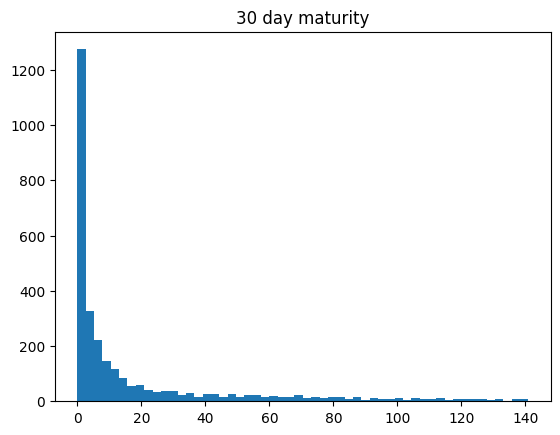

days_to_maturity
60      0.903477
60      2.601872
60    144.503154
60      0.000000
60      0.623038
         ...    
60      0.000000
60     35.106894
60     58.265225
60      0.000000
60      0.000000
Name: barrier_price, Length: 3000, dtype: float64


<Figure size 640x480 with 0 Axes>

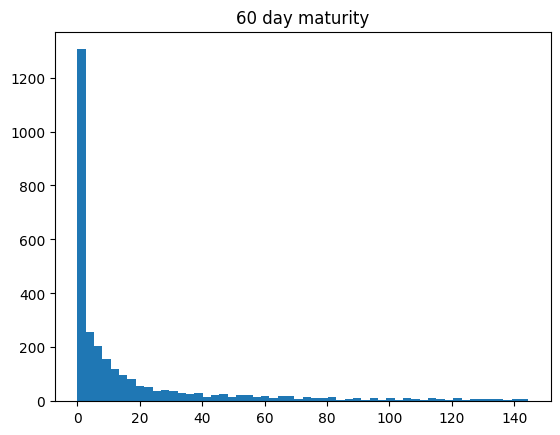

days_to_maturity
90      0.529760
90      2.680310
90    146.917141
90      0.000000
90      0.350231
         ...    
90      0.000000
90     30.735874
90     59.533529
90      0.000000
90      0.000000
Name: barrier_price, Length: 3000, dtype: float64


<Figure size 640x480 with 0 Axes>

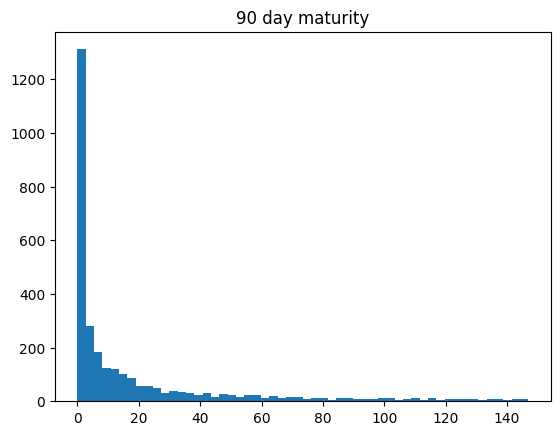

days_to_maturity
180      0.427199
180      1.843785
180    153.617003
180      0.000000
180      0.277605
          ...    
180      0.000000
180     20.183804
180     62.392829
180      0.000000
180      0.000000
Name: barrier_price, Length: 3000, dtype: float64


<Figure size 640x480 with 0 Axes>

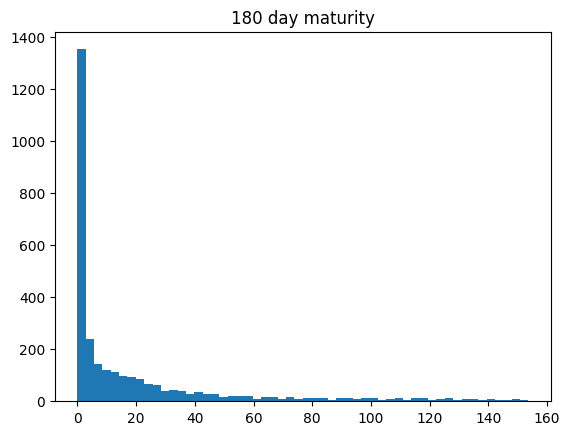

days_to_maturity
360      0.361884
360      3.960572
360    166.342106
360      0.000000
360      0.231591
          ...    
360      0.000000
360      6.063734
360     63.933624
360      0.136306
360      0.000000
Name: barrier_price, Length: 3000, dtype: float64


<Figure size 640x480 with 0 Axes>

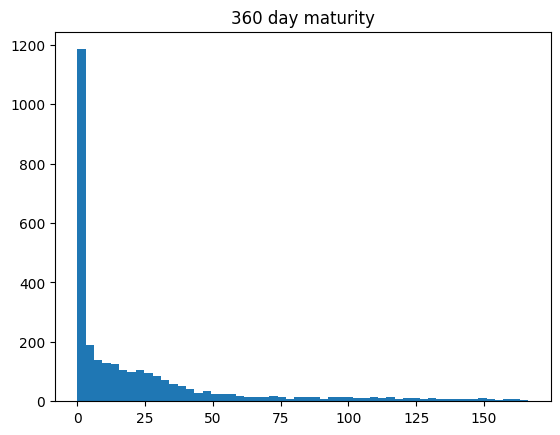

days_to_maturity
540      0.309455
540     10.694363
540    178.282575
540      0.000000
540      0.205683
          ...    
540      0.239419
540      0.239098
540     63.667139
540      4.011787
540      1.604642
Name: barrier_price, Length: 3000, dtype: float64


<Figure size 640x480 with 0 Axes>

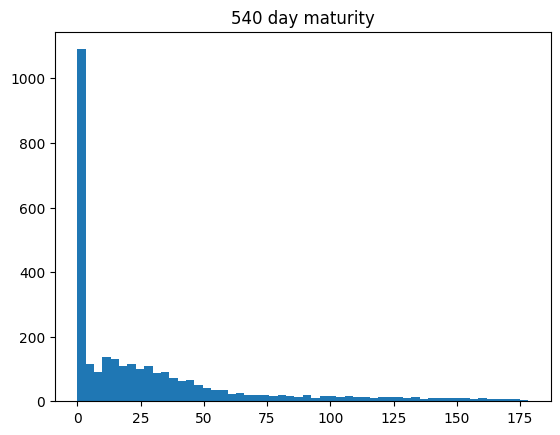

days_to_maturity
720      0.272989
720     16.020608
720    189.521357
720      0.000000
720      0.192373
          ...    
720      4.226349
720      0.000000
720     64.890367
720     10.921124
720      8.484834
Name: barrier_price, Length: 3000, dtype: float64


<Figure size 640x480 with 0 Axes>

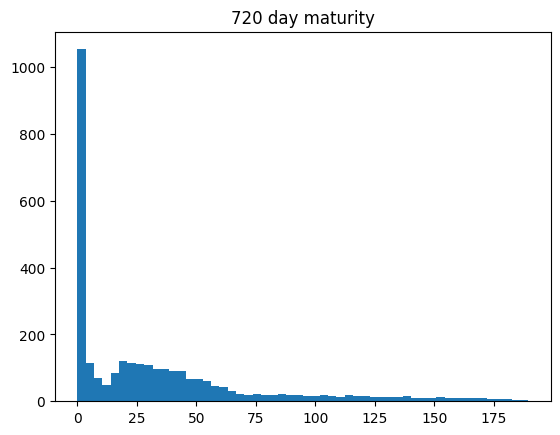

<Figure size 640x480 with 0 Axes>

In [18]:
for t in T:
    plt.figure()
    prices = featuresby_t.loc[t,'barrier_price']
    print(prices)
    plt.hist(prices,bins=int(np.sqrt(prices.shape[0])))
    plt.title(f'{t} day maturity')
    plt.show()
    plt.clf()

# model training

In [ ]:
import convsklearn
help(convsklearn)

In [ ]:
from convsklearn import barrier_trainer
barrier_trainer.solver = 'lbfgs'
barrier_trainer.activation_function = 'tanh'
features['observed_price'] = np.maximum(features['barrier_price'] + np.random.normal(scale=(0.15)**2,size=features.shape[0]),0)
    # apply slight peturbation
train_data = features[features['days_to_maturity']!=720]
test_data = features[features['days_to_maturity']==720]
print(f"train data count: {train_data.shape[0]}")
print(f"test data count: {test_data.shape[0]}")
arrs = barrier_trainer.get_train_test_arrays(train_data,test_data)
train_X = arrs['train_X']
train_y = arrs['train_y']
test_X = arrs['test_X']
test_y = arrs['train_y']
preprocessor = barrier_trainer.preprocess()

In [ ]:
dnn_barriers, runtime, specs = barrier_trainer.run_dnn(preprocessor, train_X, train_y)

In [ ]:
in_sample, out_of_sample, errors = barrier_trainer.test_prediction_accuracy(dnn_barriers, test_data, train_data)
outsample = out_of_sample.rename(
    columns = {
        'strike_price':'k',
        'days_to_maturity':'t',
        'barrier_type_name':'type',
        'barrier_price':'price',
        'vanilla_price':'vanilla',
        'spot_price':'spot',
        'outofsample_target':'target',
        'outofsample_prediction':'dnn',
        'outofsample_error':'error',
        'barrier':'b'
        }
)
outsample = outsample[[
    'spot', 'k', 'b','price', 'vanilla', 'type', 'w','t', 
    'target', 'dnn', 'error'
]]
print(f"\n{dnn_barriers}")

In [ ]:
pd.set_option("display.float_format", "{:.2f}".format)
pd.set_option("display.max_rows",None)
print(f"\n{outsample.describe()}")
outsample_preview = outsample.copy().sort_values(by=['w','type','k','b'],ascending=False).reset_index(drop=True)
print(f"\n{symbol} down barrier options for {notebook_printdate}")

target = pd.Series(np.sort(outsample_preview['target']))
estimate = pd.Series(np.sort(outsample_preview.iloc[:,-2]))
np.array(target.index)
plt.figure()
plt.scatter(target,estimate,color='purple',s=0.1)
plt.ylabel('price')
plt.xlabel('ordinal position')
plt.show()
outsample_preview

In [ ]:
pd.reset_option("display.max_rows")
pd.reset_option("display.float_format") 